In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import re
from glob import glob
import pandas as pd
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [2]:
all_cases_df = pd.read_table('./data/Info.txt', delimiter=' ')
all_cases_df = all_cases_df[all_cases_df.columns[:-1]] # drop last column
all_cases_df['path'] = all_cases_df['REFNUM'].map(lambda x: './data/%s.pgm' % x)
all_cases_df.sample(3)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,path
232,mdb227,G,CALC,B,504.0,467.0,9.0,./data/mdb227.pgm
301,mdb294,F,NORM,NaN,NaN,NaN,NaN,./data/mdb294.pgm
269,mdb262,D,NORM,NaN,NaN,NaN,NaN,./data/mdb262.pgm


In [4]:
# load all the scans
print(all_cases_df['path'])
all_cases_df['scan'] = all_cases_df['path'].map(read_pgm)
# remove the extracted files
!rm *.pgm
# show a sample
all_cases_df.sample(1)

0      ./data/mdb001.pgm
1      ./data/mdb002.pgm
2      ./data/mdb003.pgm
3      ./data/mdb004.pgm
4      ./data/mdb005.pgm
5      ./data/mdb005.pgm
6      ./data/mdb006.pgm
7      ./data/mdb007.pgm
8      ./data/mdb008.pgm
9      ./data/mdb009.pgm
10     ./data/mdb010.pgm
11     ./data/mdb011.pgm
12     ./data/mdb012.pgm
13     ./data/mdb013.pgm
14     ./data/mdb014.pgm
15     ./data/mdb015.pgm
16     ./data/mdb016.pgm
17     ./data/mdb017.pgm
18     ./data/mdb018.pgm
19     ./data/mdb019.pgm
20     ./data/mdb020.pgm
21     ./data/mdb021.pgm
22     ./data/mdb022.pgm
23     ./data/mdb023.pgm
24     ./data/mdb024.pgm
25     ./data/mdb025.pgm
26     ./data/mdb026.pgm
27     ./data/mdb027.pgm
28     ./data/mdb028.pgm
29     ./data/mdb029.pgm
             ...        
300    ./data/mdb293.pgm
301    ./data/mdb294.pgm
302    ./data/mdb295.pgm
303    ./data/mdb296.pgm
304    ./data/mdb297.pgm
305    ./data/mdb298.pgm
306    ./data/mdb299.pgm
307    ./data/mdb300.pgm
308    ./data/mdb301.pgm


'rm' is not recognized as an internal or external command,
operable program or batch file.


,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,path,scan
282,mdb275,G,NORM,NaN,NaN,NaN,NaN,./data/mdb275.pgm,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 198..."


In [5]:
import h5py
from tqdm import tqdm
from warnings import warn
def write_df_as_hdf(out_path, out_df):
    with h5py.File(out_path, 'w') as h:
        for k, arr_dict in tqdm(out_df.to_dict().items()): 
            try:
                s_data = np.stack(arr_dict.values(), 0)

                try:
                    h.create_dataset(k, data = s_data, compression = 'gzip')
                except TypeError as e: 
                    try:
                        h.create_dataset(k, data = s_data.astype(np.string_))
                    except TypeError as e2: 
                        print('%s could not be added to hdf5, %s' % (k, repr(e), repr(e2)))

            except ValueError as e:
                print('%s could not be created, %s' % (k, repr(e)))
                all_shape = [np.shape(x) for x in arr_dict.values()]
write_df_as_hdf('all_mias_scans.h5', all_cases_df)

d:\Users\yhuangde\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s]


In [6]:
# check the hdf5 file
print('Filesize: %2.2f mb' % (os.stat('all_mias_scans.h5').st_size/1e6))
with h5py.File('all_mias_scans.h5', 'r') as f:
    for k,v in f.items():
        print(k, v.shape)

Filesize: 105.08 mb
BG (330,)
CLASS (330,)
RADIUS (330,)
REFNUM (330,)
SEVERITY (330,)
X (330,)
Y (330,)
path (330,)
scan (330, 1024, 1024)


d:\Users\yhuangde\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)


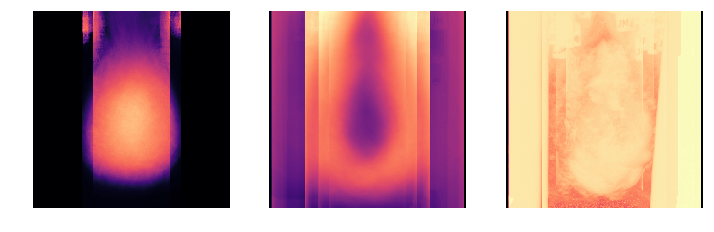

In [8]:
f_stack = np.stack([x.astype(np.float32)[::2, ::2] for x in all_cases_df['scan'].values],0)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 8))
ax1.imshow(np.median(f_stack,0), cmap = 'magma')
ax1.axis('off')
ax2.imshow(np.std(f_stack,0), cmap = 'magma')
ax2.axis('off')
ax3.imshow(np.max(f_stack,0), cmap = 'magma')
ax3.axis('off')
fig.savefig('stack_images.pdf')

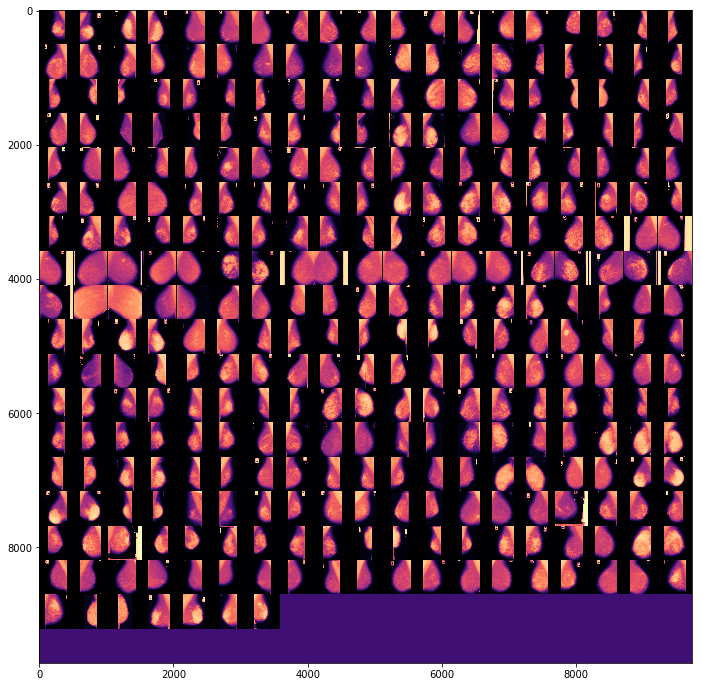

In [9]:
from skimage.util.montage import montage2d
fig, ax1 = plt.subplots(1,1, figsize = (12, 12))
ax1.imshow(montage2d(f_stack), cmap = 'magma')
fig.savefig('montage.png')